# 多GPU训练

In [28]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

为什么要多GPU训练，一般来说2个原因：1）模型太大，一个GPU放不下；2）单个GPU跑起来太慢，希望能够用多GPU来加速

早期的GPU显存一般在4个G左右，单个模型需要的显存很容易就超过了显存大小，但是现在新的GPU显存都越来越大，达到了32G，所以当前模型的占用显存太大的问题一般还好。更多的都是为了追求第2点，希望多个GPU能起到线性加速的效果。

多GPU的训练的并行模式主流的有以下3种，一般前2种称为模型并行，后一种称为数据并行。

- 将整个模型大深度方向上拆成若干个子网络，每个子网络跑在一块GPU上，这就需要GPU与GPU之间传递激活值与梯度值；很容易让GPU之间的传输带宽达到瓶颈。这种方案另外一个问题是，GPU之间有信赖关系，因为反向传播一般都需要前向计算完成后，才能开始，这就导致了GPU与GPU之间有等待的问题，但这个问题也可以通过对单批次的数据进行多次拆分，做成流水线一定程度解决。总之效率不太高。
- 将整个网络在宽度上拆分，对于卷积层就是拆分通道，每个GPU计算一部分通道，计算完成后，要再结合同步到各GPU上。对于FC层，就直接对隐藏层进行拆分，每块GPU计算一部分隐藏层的值，然后再分发同步。这种方式GPU之间数据交互非常频繁，但GPU的利用率可能会比上面一种方案高一些。
- 对数据进行拆分，将一个miniBatch拆成更小的batch，每块GPU做其中的一块。这样的方式，只需要在各GPU前向后，把梯度gather起来，再分发出去，就可以了。

![](./images/splitting.svg)

上图中描述了多个GPU上不同并行方式的比较。总的来说，数据并行是最方便的方法，只要我们能访问有足够大显存的GPU。

# 数据并行

对于K块GPU的数据并行来说，训练过程如下：

* 在训练的任何迭代中，给定一个随机的小批量，我们将该小批量中的样本分成K个部分，并将它们均匀地分在多个GPU上。
* 每个GPU根据分配给它的小批量子集计算模型参数的损失和梯度。
* 将K个GPU中每个GPU的局部梯度聚合以获得当前的小批量随机梯度。
* 聚合梯度被重新分配到每个GPU。
* 每个GPU使用这个小批量随机梯度来更新它维护的完整的模型参数集。

数据并行需要特别注意的问题：1)batchsize； 2）learningrate；3) batchnorm层的处理

# 辅助函数

In [5]:
import typing
import torch
from typing import Tuple, List

## 拷贝模型参数到其他设备

In [18]:
# 获取指定device上的数据所拷贝
def get_params(params: List[torch.Tensor], device: torch.device):
    new_params = [param.clone().to(device) for param in params]
    for param in new_params:
        param.required_grad_(True)
    return new_params

## 参数的AllRedice

In [10]:
# 将不同设备上的数据reduce在一起，再分发出来
def all_reduce(data: List[torch.Tensor]):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [21]:
a1 = torch.randn(3,4,device='cuda:0')
a2 = torch.randn(3,4,device='cuda:1')
print(a1)
print(a2)
all_reduce([a1, a2])
print('after all reduce')
print(a1)
print(a2)

tensor([[ 1.2432,  1.5609,  0.2156,  0.2249],
        [-1.3757,  1.7969,  0.0739, -0.7031],
        [ 0.1215, -1.1703,  2.0395,  0.3356]], device='cuda:0')
tensor([[-1.6571, -0.7840,  1.2169,  0.6460],
        [-1.3433, -0.5825,  1.0806,  0.5943],
        [ 1.3376, -0.6009,  0.5722,  3.2728]], device='cuda:1')
after all reduce
tensor([[-0.4138,  0.7768,  1.4324,  0.8709],
        [-2.7190,  1.2144,  1.1545, -0.1088],
        [ 1.4590, -1.7712,  2.6117,  3.6084]], device='cuda:0')
tensor([[-0.4138,  0.7768,  1.4324,  0.8709],
        [-2.7190,  1.2144,  1.1545, -0.1088],
        [ 1.4590, -1.7712,  2.6117,  3.6084]], device='cuda:1')


## 数据拆分

In [25]:
from torch import nn

In [26]:
data = torch.randn(12, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1'), torch.device('cuda:2'), torch.device('cuda:3')]
data_shards = nn.parallel.scatter(data, devices)

In [27]:
data_shards

(tensor([[ 0.8486, -0.7641,  0.0142,  1.2357, -1.1229],
         [-1.9956, -1.0953,  0.1090, -0.0231, -0.6757],
         [-1.4356, -0.5834, -0.6698,  1.4030,  0.5050]], device='cuda:0'),
 tensor([[-0.2713,  0.3155, -0.2146, -1.4422, -0.2556],
         [-2.6946, -1.0870,  1.1156, -0.4161, -0.9118],
         [ 0.7342,  0.4245, -0.7815, -1.1491, -0.3895]], device='cuda:1'),
 tensor([[ 0.0750,  0.9603,  0.5198, -1.6211, -0.4285],
         [-0.4152, -1.1381,  1.2842, -0.8610, -0.2459],
         [-0.9289, -0.3966, -1.0761, -0.8112, -0.6451]], device='cuda:2'),
 tensor([[-0.7597,  0.8775,  1.3511,  1.7254, -1.1145],
         [-0.1952, -0.2889, -1.5922, -1.2989,  0.0033],
         [ 1.7823,  0.5397, -2.2869,  1.7974, -0.7552]], device='cuda:3'))

# 多GPU训练伪代码

In [ ]:
def multi_gpu_train_1_epoch(model, training_data, devices, loss, sgd):
    models = [model.to(device) for device in devices]
    for X, y in training_data:
        X_devices = nn.parallel.scatter(X, devices)
        y_devices = nn.parallel.scatter(y, devices)
        for i in range(len(device)):
            y_hat = models[i](X_devices[i])
            l = loss(y[i], y_hat)
            l.backward()
        with torch.no_grad():
            all_reduce([model.parameters() for model in models])
        for i in range(len(device)):
            # sgd里会有no_grad
            sgd(model[i].parameters(), lr)

# 使用Pytorch的多GPU并行

和单GPU下的几点不同：
- 模型需要调用`nn.DataParallel`转化成并行化的model
- 数据和参数一开始放在第一块卡上

最终性能大约是单GPU下的3倍多（9m vs. 28m）。

In [30]:
trans = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
training_data_224 = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=trans
)
testing_data_224 = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=trans
)

In [41]:
def accuracy(y_hat, y):
    max_indices = torch.max(y_hat, dim=1)[1]
    return (y == max_indices).to(dtype=torch.float32).mean()


def accuracy_on(model, data_iter, device):
    model.train(False)
    acc = []
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        acc.append(accuracy(y_hat, y))
    return torch.tensor(acc).mean().item()


def multigpu_train(training_iter, testing_iter, model, loss, optimizer, devices, epoch=20, plot=True):
    training_loss = []
    training_acc = []
    testing_acc = []
    for i in range(epoch):
        epoch_loss = 0
        epoch_acc = 0
        model.train(True)
        for X, y in training_iter:
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = model(X)
            l = loss(y_hat, y)
            epoch_loss += l.item()
            epoch_acc += accuracy(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        training_loss.append(epoch_loss / len(training_iter))
        training_acc.append(epoch_acc / len(training_iter))
        testing_acc.append(accuracy_on(model, testing_iter, devices[0]))
        print(
            f'the loss of epoch {i}: {training_loss[-1]:.4f}, accuracy on training set: {training_acc[-1]:.4f}, accuracy on testing set: {testing_acc[-1]:.4f}')
    if plot == False:
        return
    plt.plot(training_loss, label='training_loss')
    plt.plot(training_acc, label='training_acc')
    plt.plot(testing_acc, label='testing_acc')
    plt.legend()
    plt.show()

[device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]
the loss of epoch 0: 0.5908, accuracy on training set: 0.8063, accuracy on testing set: 0.8760
the loss of epoch 1: 0.2750, accuracy on training set: 0.9001, accuracy on testing set: 0.8849
the loss of epoch 2: 0.2131, accuracy on training set: 0.9231, accuracy on testing set: 0.8943
the loss of epoch 3: 0.1762, accuracy on training set: 0.9360, accuracy on testing set: 0.8644
the loss of epoch 4: 0.1408, accuracy on training set: 0.9500, accuracy on testing set: 0.9205
the loss of epoch 5: 0.1111, accuracy on training set: 0.9608, accuracy on testing set: 0.9120
the loss of epoch 6: 0.0772, accuracy on training set: 0.9732, accuracy on testing set: 0.8878
the loss of epoch 7: 0.0577, accuracy on training set: 0.9805, accuracy on testing set: 0.9152
the loss of epoch 8: 0.0382, accuracy on training set: 0.9879, accuracy on testing set: 0.9122
the loss of epoch 9: 0.0

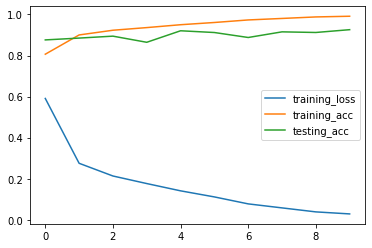

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_1x1conv=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
    def forward(self, x):
        output = self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))
        if self.conv3:
            x = self.conv3(x)
        return F.relu(output + x)
    
batch_size = 128
learning_rate = 0.1
epoch = 10
num_device = 4
devices = [torch.device('cuda:{}'.format(i)) for i in range(num_device)]

training_iter = torch.utils.data.DataLoader(
    training_data_224, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(
    testing_data_224, batch_size=batch_size)

s1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, padding=3, stride=2),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU()
)
s2 = nn.Sequential(
    nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
)
s3 = nn.Sequential(
    ResidualBlock(64, 128, stride=2, use_1x1conv=True),
    ResidualBlock(128, 128),
)
s4 = nn.Sequential(
    ResidualBlock(128, 256, stride=2, use_1x1conv=True),
    ResidualBlock(256, 256),
)
s5 = nn.Sequential(
    ResidualBlock(256, 512, stride=2, use_1x1conv=True),
    ResidualBlock(512, 512),
)

model=nn.Sequential(s1, s2, s3, s4, s5, nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10))

def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
print(devices)
model.apply(parameters_init)
model = nn.DataParallel(model, device_ids=devices)
model.to(device=devices[0])
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
multigpu_train(training_iter, testing_iter, model, loss, optimizer, devices=devices, epoch=epoch, plot=True)